In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import Datasets**

In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Load the Dataset ---
file_path = '/content/drive/MyDrive/spambase/spambase_csv.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# --- Step 2: Initial Dataset Summary ---
print("🔍 Dataset Shape:", df.shape)
print("\n📌 First 5 Rows:\n", df.head())
print("\n📊 Summary Statistics:\n", df.describe(include='all'))
print("\n🧾 Column Info:")
df.info()

# --- Step 3: Missing Value Analysis ---
missing_counts = df.isnull().sum()
print("\n❗ Missing Values per Column:\n", missing_counts[missing_counts > 0])

# --- Step 4: Imputation (Handling Missing Values) ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            # Fill categorical columns with mode
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"Filled missing values in '{col}' with mode: {mode_value}")
        else:
            # Fill numeric columns with median
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            print(f"Filled missing values in '{col}' with median: {median_value}")

# --- Step 5: Final Check ---
print("\n✅ Missing Values After Imputation:\n", df.isnull().sum().sum())

# (Optional) Save cleaned dataset
# df.to_csv('/content/drive/MyDrive/cleaned_dataset.csv', index=False)


🔍 Dataset Shape: (4601, 58)

📌 First 5 Rows:
    word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_%3B  char_freq_%28  \
0             0.00   

**2. Handling Missing Values - Impute numerival columns with mean and categorical columns with mode**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Step 1: Load Dataset ---
file_path = '/content/drive/MyDrive/spambase/spambase_csv.csv'
df = pd.read_csv(file_path)

# --- Step 2: Impute Missing Values ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

# --- Step 3: Identify Categorical Columns ---
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# --- Step 4: Apply One-Hot Encoding using ColumnTransformer ---
if categorical_cols:
    print("Encoding categorical columns:", categorical_cols)

    column_transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'  # Keep all other columns
    )

    transformed = column_transformer.fit_transform(df)
    feature_names = column_transformer.get_feature_names_out()

    df = pd.DataFrame(transformed, columns=feature_names)

else:
    print("No categorical columns found.")
    df = df.copy()

# --- Step 5: Boxplot Analysis (3 per row) ---
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_plots = len(numeric_cols)
cols_per_row = 3
rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 5 * rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle("Boxplot Analysis of Numerical Columns", fontsize=16, y=1.02)
plt.show()


No categorical columns found.


**3. Detecting Outliers and Capping them using IQR**

In [ ]:
# Create a copy to apply capping
capped_df = df.copy()

print("\n🔍 Capping outliers using IQR method:")

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        print(f"{col}: {len(outliers)} outliers capped")
        capped_df[col] = np.where(capped_df[col] < lower_bound, lower_bound,
                            np.where(capped_df[col] > upper_bound, upper_bound, capped_df[col]))
    else:
        print(f"{col}: No outliers detected")



import math


df = capped_df.copy()



def plot_boxplots_grid(df, columns, per_row=2):
    n = len(columns)
    rows = (n + per_row - 1) // per_row
    fig, axes = plt.subplots(rows, per_row, figsize=(6 * per_row, 4 * rows))

    # Flatten axes array in case of multiple rows
    axes = axes.flatten()

    for idx, col in enumerate(columns):
        data = df[col].dropna()
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        spread = data.max() - data.min()

        # Avoid completely flat plots by scaling y-limits
        padding = spread * 0.1 if spread > 0 else 1e-3
        y_min = data.min() - padding
        y_max = data.max() + padding

        ax = axes[idx]
        sns.boxplot(y=data, ax=ax)
        ax.set_ylim([y_min, y_max])
        ax.set_title(f'{col} (IQR: {IQR:.3f})')
        ax.grid(True)

    # Hide any unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plot_boxplots_grid(df, numerical_columns)



🔍 Capping outliers using IQR method:
word_freq_make: 1053 outliers capped
word_freq_address: 898 outliers capped
word_freq_all: 338 outliers capped
word_freq_3d: 47 outliers capped
word_freq_our: 501 outliers capped
word_freq_over: 999 outliers capped
word_freq_remove: 807 outliers capped
word_freq_internet: 824 outliers capped
word_freq_order: 773 outliers capped
word_freq_mail: 852 outliers capped
word_freq_receive: 709 outliers capped
word_freq_will: 270 outliers capped
word_freq_people: 852 outliers capped
word_freq_report: 357 outliers capped
word_freq_addresses: 336 outliers capped
word_freq_free: 957 outliers capped
word_freq_business: 963 outliers capped
word_freq_email: 1038 outliers capped
word_freq_you: 75 outliers capped
word_freq_credit: 424 outliers capped
word_freq_your: 229 outliers capped
word_freq_font: 117 outliers capped
word_freq_000: 679 outliers capped
word_freq_money: 735 outliers capped
word_freq_hp: 1090 outliers capped
word_freq_hpl: 811 outliers capped
word

**4. Normalisation**


🧪 Normalizing Numerical Columns Based on Distribution and Outliers:

word_freq_make: No outliers and not Gaussian → Min-Max normalization applied
word_freq_address: No outliers and not Gaussian → Min-Max normalization applied
word_freq_all: No outliers and not Gaussian → Min-Max normalization applied
word_freq_3d: No outliers and not Gaussian → Min-Max normalization applied
word_freq_our: No outliers and not Gaussian → Min-Max normalization applied
word_freq_over: No outliers and not Gaussian → Min-Max normalization applied
word_freq_remove: No outliers and not Gaussian → Min-Max normalization applied
word_freq_internet: No outliers and not Gaussian → Min-Max normalization applied
word_freq_order: No outliers and not Gaussian → Min-Max normalization applied
word_freq_mail: No outliers and not Gaussian → Min-Max normalization applied
word_freq_receive: No outliers and not Gaussian → Min-Max normalization applied
word_freq_will: No outliers and not Gaussian → Min-Max normalization appli

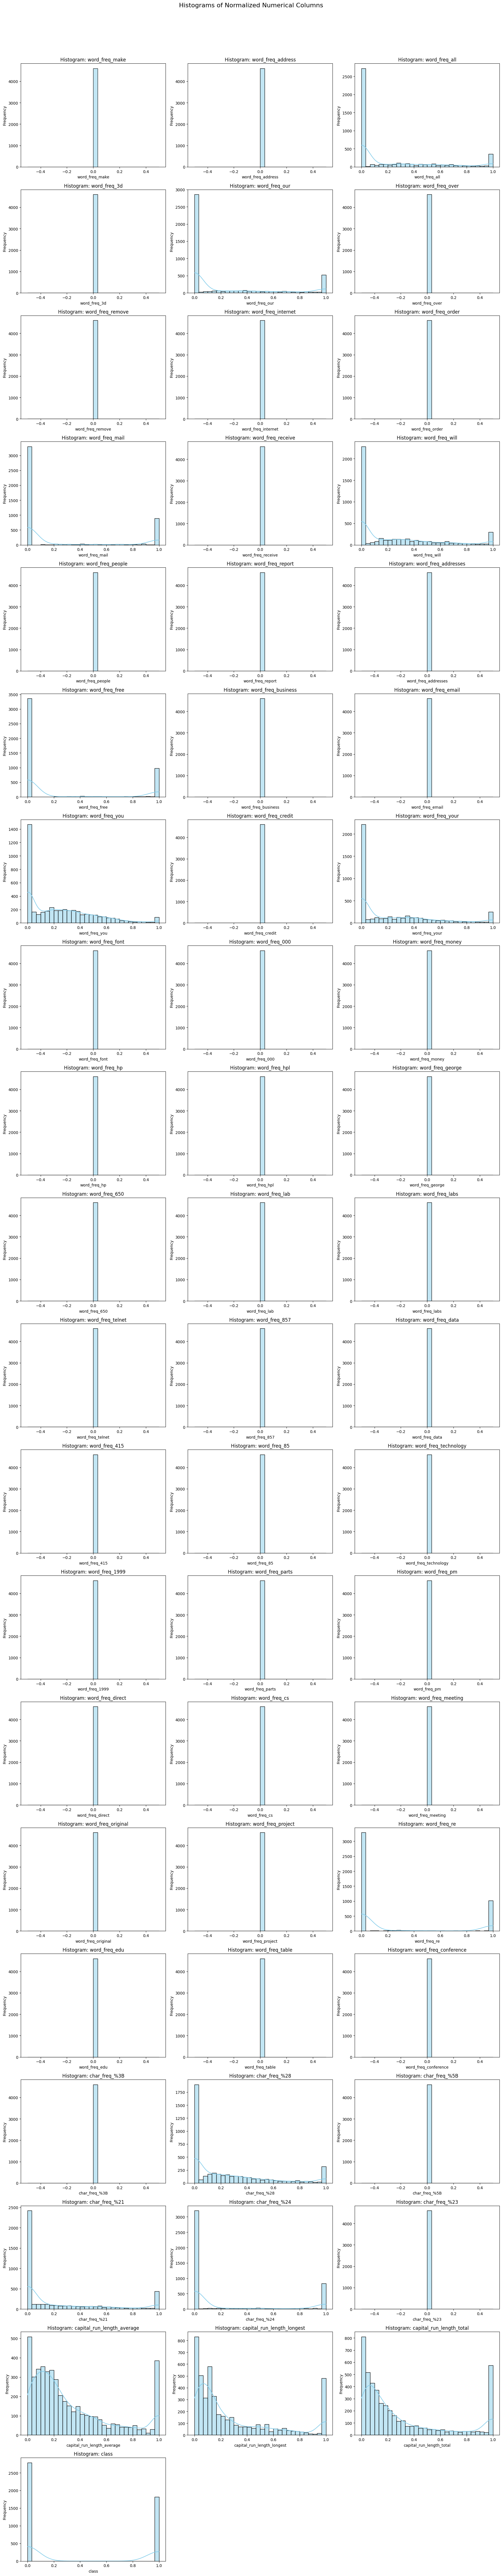

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, normaltest
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Get Numerical Columns ---
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# --- Step 2: Create New DataFrame for Normalized Data ---
normalized_df = df.copy()

print("\n🧪 Normalizing Numerical Columns Based on Distribution and Outliers:\n")

# --- Step 3: Normalize Each Column Based on Condition ---
for col in numeric_cols:
    data = df[col]

    # Detect outliers using Z-score
    z_scores = zscore(data)
    outliers = np.where(np.abs(z_scores) > 3)[0]

    # Test for normal distribution
    stat, p_value = normaltest(data)

    if len(outliers) > 0 or p_value > 0.05:
        # Apply Z-score normalization
        normalized_df[col] = zscore(data)
        print(f"{col}: Outliers or normal distribution → Z-score normalization applied")
    else:
        # Apply Min-Max normalization
        scaler = MinMaxScaler()
        normalized_df[col] = scaler.fit_transform(data.values.reshape(-1, 1))
        print(f"{col}: No outliers and not Gaussian → Min-Max normalization applied")


# --- Plot Histograms After Normalization (3 per row) ---


cols_per_row = 3
num_plots = len(numeric_cols)
rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 4.5 * rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(normalized_df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Histogram: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.suptitle("Histograms of Normalized Numerical Columns", fontsize=16, y=1.02)
plt.show()


**5. Train, Test Split and Model building**

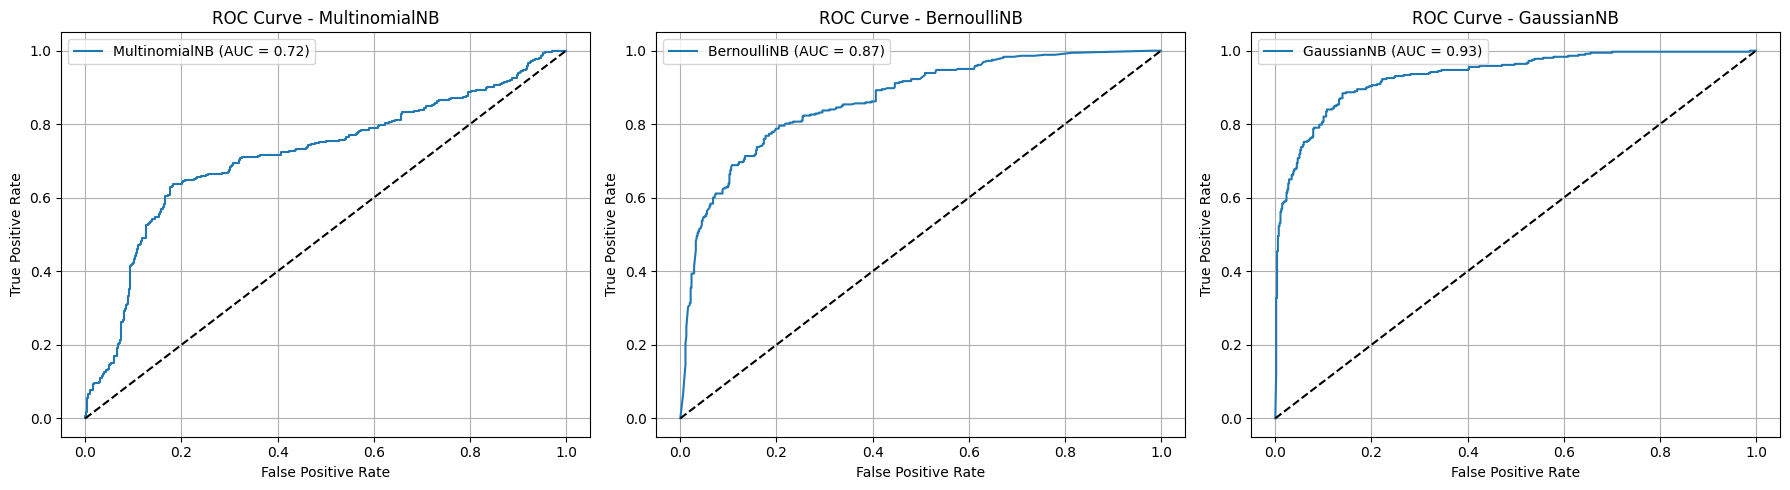

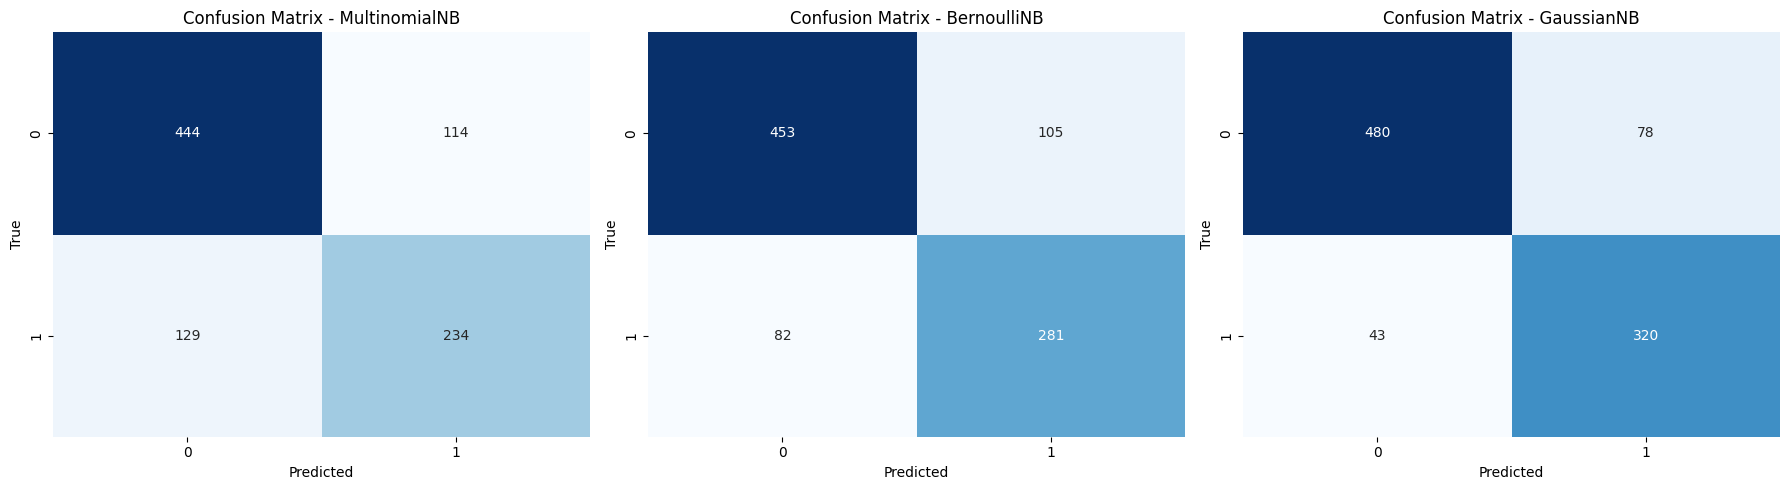

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, confusion_matrix,
    classification_report, matthews_corrcoef, roc_auc_score,
    roc_curve
)

# --- Step 1: Split dataset ---
X = df.drop("class", axis=1)  # features
y = df["class"]  # target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# --- Step 2: Train Models ---
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB()

}

preds = {}
probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    preds[name] = y_pred
    probas[name] = y_proba
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# --- ROC Curve Plots in 1 row ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, name in enumerate(models):
    fpr, tpr, _ = roc_curve(y_test, probas[name])
    axs[i].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, probas[name]):.2f})')
    axs[i].plot([0, 1], [0, 1], 'k--')
    axs[i].set_title(f"ROC Curve - {name}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    axs[i].legend()
    axs[i].grid()
plt.tight_layout()
plt.show()

# --- Residual Plots in 1 row ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, name in enumerate(models):
    residuals = y_test - preds[name]
    axs[i].scatter(range(len(residuals)), residuals, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(f"Residual Plot - {name}")
    axs[i].set_xlabel("Sample Index")
    axs[i].set_ylabel("Residual (True - Pred)")
    axs[i].grid()
plt.tight_layout()
plt.show()

# --- Confusion Matrix Heatmaps in 1 row ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[i],
                xticklabels=model.classes_ if hasattr(model, "classes_") else None,
                yticklabels=model.classes_ if hasattr(model, "classes_") else None)
    axs[i].set_title(f"Confusion Matrix - {name}")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("True")
plt.tight_layout()
plt.show()



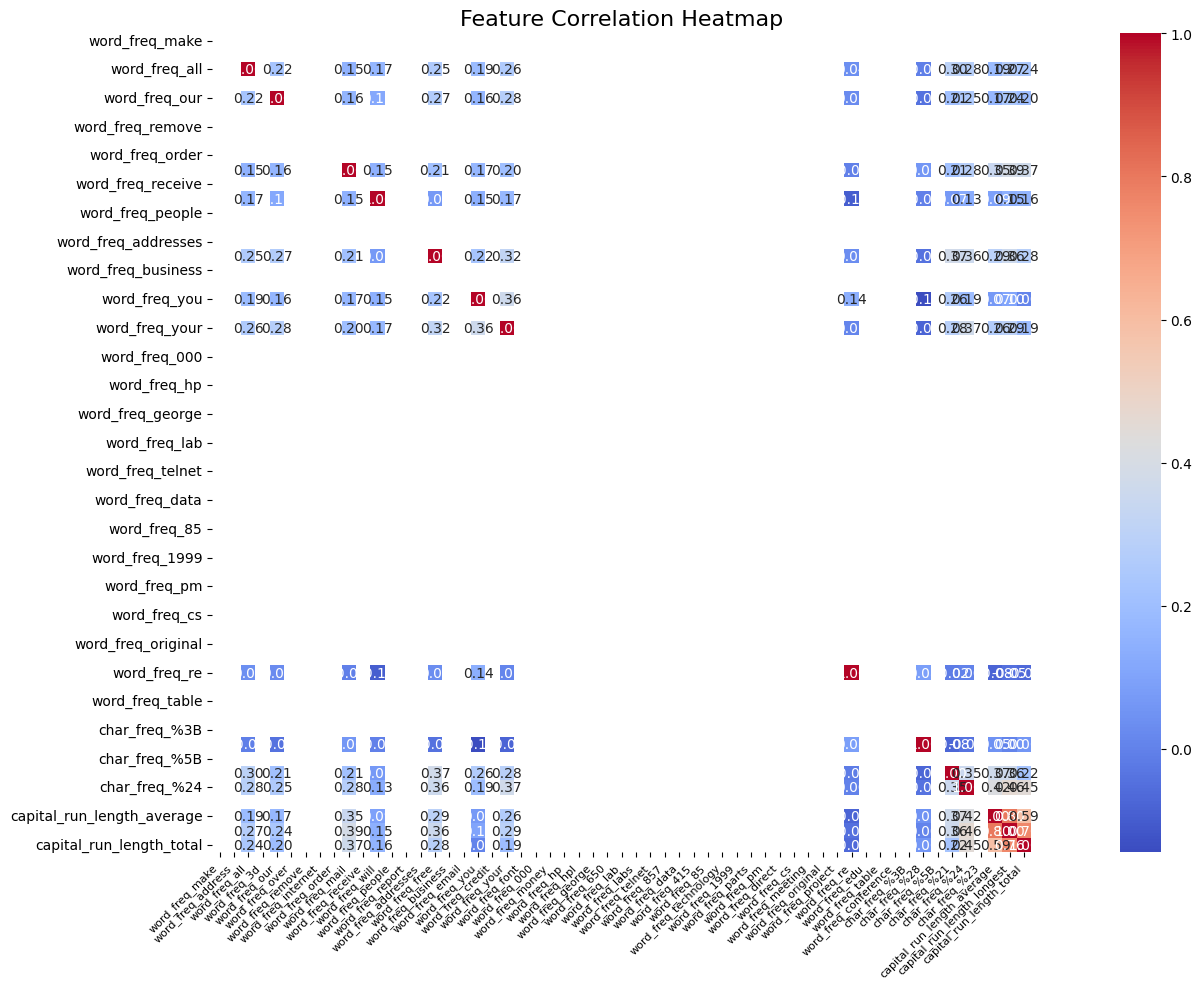

In [ ]:
# --- Step 6: Correlation Heatmap (Larger Plot) ---
plt.figure(figsize=(18, 10))  # Increased width and height
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



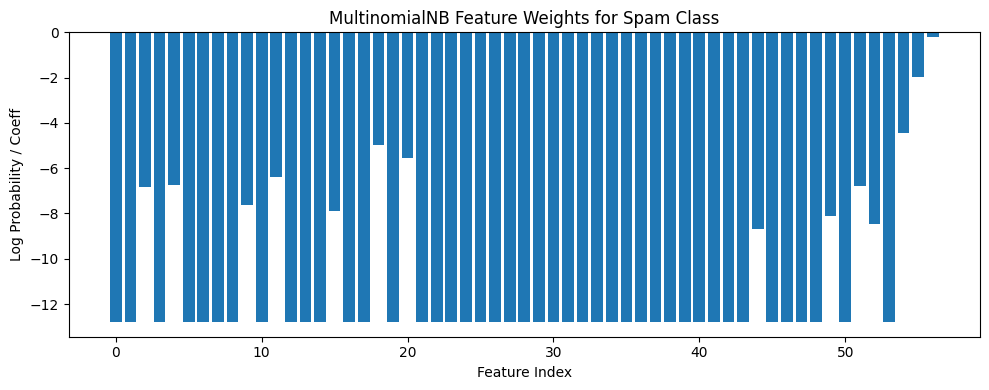

In [ ]:

# --- Step 7: Coefficient Weights Plot (Naive Bayes only) ---
def plot_coefficients(model, model_name):
    if hasattr(model, 'coef_'):
        coef = model.coef_[0]
    else:
        coef = model.feature_log_prob_[1]  # Class 1 (spam)
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(coef)), coef)
    plt.title(f"{model_name} Feature Weights for Spam Class")
    plt.xlabel("Feature Index")
    plt.ylabel("Log Probability / Coeff")
    plt.tight_layout()
    plt.show()

plot_coefficients(models["MultinomialNB"], "MultinomialNB")
plot_coefficients(models["BernoulliNB"], "BernoulliNB")


**Evaluation**


📊 Performance of MultinomialNB Model:
➡ Accuracy         : 0.7362
➡ Precision (Wgt)  : 0.7345
➡ Recall    (Wgt)  : 0.7362
➡ F1 Score  (Wgt)  : 0.7351

🧩 Confusion Matrix:
[[444 114]
 [129 234]]

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       558
           1       0.67      0.64      0.66       363

    accuracy                           0.74       921
   macro avg       0.72      0.72      0.72       921
weighted avg       0.73      0.74      0.74       921

⚠️ ROC-AUC/Log Loss not available for this output.



📊 Performance of BernoulliNB Model:
➡ Accuracy         : 0.7970
➡ Precision (Wgt)  : 0.7999
➡ Recall    (Wgt)  : 0.7970
➡ F1 Score  (Wgt)  : 0.7979

🧩 Confusion Matrix:
[[453 105]
 [ 82 281]]

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       558
           1       0.73      0.77      0.75       363

    accuracy                           0.80       921
   macro avg       0.79      0.79      0.79       921
weighted avg       0.80      0.80      0.80       921

⚠️ ROC-AUC/Log Loss not available for this output.


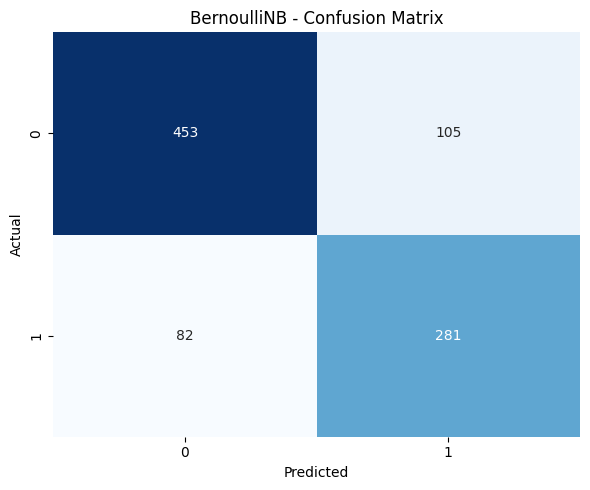


📊 Performance of GaussianNB Model:
➡ Accuracy         : 0.8686
➡ Precision (Wgt)  : 0.8729
➡ Recall    (Wgt)  : 0.8686
➡ F1 Score  (Wgt)  : 0.8695

🧩 Confusion Matrix:
[[480  78]
 [ 43 320]]

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       558
           1       0.80      0.88      0.84       363

    accuracy                           0.87       921
   macro avg       0.86      0.87      0.86       921
weighted avg       0.87      0.87      0.87       921

⚠️ ROC-AUC/Log Loss not available for this output.


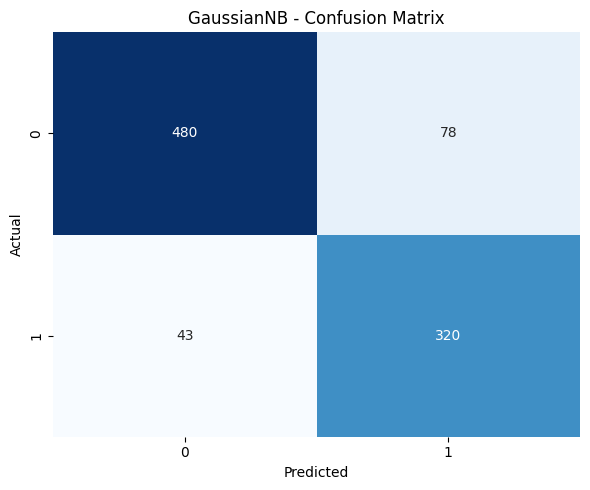

In [ ]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    log_loss, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, y_true, y_pred, y_proba=None):
    print(f"\n📊 Performance of {name} Model:")

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"➡ Accuracy         : {acc:.4f}")
    print(f"➡ Precision (Wgt)  : {prec:.4f}")
    print(f"➡ Recall    (Wgt)  : {rec:.4f}")
    print(f"➡ F1 Score  (Wgt)  : {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n🧩 Confusion Matrix:")
    print(cm)

    # Classification report
    print("\n📝 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # ROC-AUC and Log Loss (only if probabilities are given)
    if y_proba is not None:
        try:
            # Handle both binary and multiclass cases
            if len(set(y_true)) == 2:
                auc_score = roc_auc_score(y_true, y_proba[:, 1])
            else:
                auc_score = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
            ll = log_loss(y_true, y_proba)

            print(f"\n🎯 ROC-AUC Score   : {auc_score:.4f}")
            print(f"📉 Log Loss        : {ll:.4f}")
        except:
            print("⚠️ ROC-AUC/Log Loss not available for this output.")

    # Optional: Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# --- Step 8: Print evaluations ---
for name in models:
    evaluate_model(name, y_test, preds[name], probas[name])

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define models
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB":GaussianNB()
}

# Perform 5-fold cross-validation
for name, model in models.items():
    print(f"\n=== 5-Fold Cross-Validation for {name} ===")
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("Accuracy scores for each fold:", scores)
    print("Mean Accuracy:", np.mean(scores))
    print("Standard Deviation:", np.std(scores))



=== 5-Fold Cross-Validation for MultinomialNB ===
Accuracy scores for each fold: [0.70792617 0.71521739 0.71630435 0.77282609 0.57826087]
Mean Accuracy: 0.6981069725723458
Standard Deviation: 0.06429053108970888

=== 5-Fold Cross-Validation for BernoulliNB ===
Accuracy scores for each fold: [0.81976113 0.82391304 0.83369565 0.85108696 0.74456522]
Mean Accuracy: 0.8146043997545203
Standard Deviation: 0.036644733973513026

=== 5-Fold Cross-Validation for GaussianNB ===
Accuracy scores for each fold: [0.87513572 0.88152174 0.88804348 0.90108696 0.7673913 ]
Mean Accuracy: 0.8626358400604259
Standard Deviation: 0.04839107821153015


**KNN**

In [ ]:
import time

# ---------------------------------------
# 8. Evaluate specific k values with metrics + training time
# ---------------------------------------
k_values = [1, 3, 5, 7]
results = {}

for k in k_values:
    print(f"\n[INFO] Evaluating KNN with k={k}")

    knn_model = KNeighborsClassifier(
        n_neighbors=k,
        weights=best_params.get('weights', 'uniform'),
        p=best_params.get('p', 2)
    )

    # Measure training time
    start_time = time.time()
    knn_model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred_k = knn_model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred_k)
    prec = precision_score(y_test, y_pred_k, average='macro')
    rec = recall_score(y_test, y_pred_k, average='macro')
    f1 = f1_score(y_test, y_pred_k, average='macro')

    # Print metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")

    # Save results
    results[k] = {
        "Accuracy": acc,
        "Precision_macro": prec,
        "Recall_macro": rec,
        "F1_macro": f1,
        "Train_Time_sec": train_time
    }

# ---------------------------------------
# 9. Summary Table
# ---------------------------------------
results_df = pd.DataFrame(results).T
print("\nKNN (specific k values) Performance Summary:\n", results_df)



[INFO] Evaluating KNN with k=1
Accuracy: 0.7926
Precision (macro): 0.7840
Recall (macro): 0.7783
F1 Score (macro): 0.7808
Training Time: 0.0097 seconds

[INFO] Evaluating KNN with k=3
Accuracy: 0.7872
Precision (macro): 0.7791
Recall (macro): 0.7705
F1 Score (macro): 0.7739
Training Time: 0.0039 seconds

[INFO] Evaluating KNN with k=5
Accuracy: 0.7861
Precision (macro): 0.7768
Recall (macro): 0.7725
F1 Score (macro): 0.7744
Training Time: 0.0044 seconds

[INFO] Evaluating KNN with k=7
Accuracy: 0.7807
Precision (macro): 0.7722
Recall (macro): 0.7632
F1 Score (macro): 0.7668
Training Time: 0.0036 seconds

KNN (specific k values) Performance Summary:
    Accuracy  Precision_macro  Recall_macro  F1_macro  Train_Time_sec
1  0.792617         0.784012      0.778311  0.780781        0.009732
3  0.787188         0.779064      0.770461  0.773935        0.003870
5  0.786102         0.776757      0.772453  0.774372        0.004364
7  0.780673         0.772231      0.763159  0.766752        0.003

Best Parameters from Random Search: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       558
           1       0.83      0.76      0.80       363

    accuracy                           0.85       921
   macro avg       0.84      0.83      0.84       921
weighted avg       0.85      0.85      0.84       921

Accuracy: 0.8458197611292074
Precision (macro): 0.8431896154436991
Recall (macro): 0.8308821351343345
F1 Score (macro): 0.8358478346002068
Matthews Corrcoef: 0.6739593836840387
ROC AUC: 0.9050746961304147


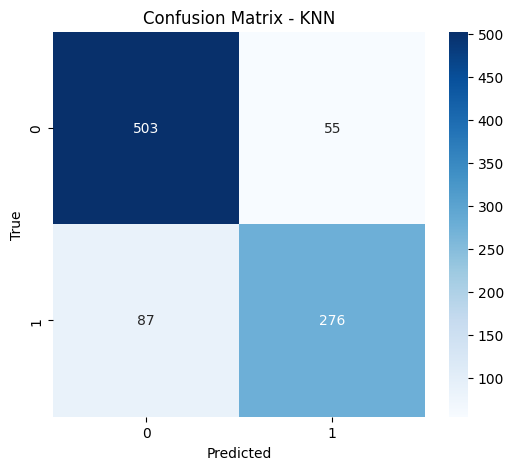


Cross-Validation Accuracy Scores: [0.7795874  0.81630435 0.8576087  0.85217391 0.7326087 ]
Mean CV Accuracy: 0.8076566114336968


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, matthews_corrcoef, roc_auc_score, roc_curve
)
from scipy.stats import randint

# ---------------------------------------
# 1. Prepare data
# ---------------------------------------
X = df.drop("class", axis=1)
y = df["class"]

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# ---------------------------------------
# 2. RandomizedSearchCV for best k
# ---------------------------------------
param_dist = {
    'n_neighbors': randint(1, 30),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) or Euclidean (2)
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(
    knn, param_distributions=param_dist, n_iter=20,
    cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters from Random Search:", best_params)

# ---------------------------------------
# 3. Train final KNN model with best params
# ---------------------------------------
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Predictions
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1] if len(np.unique(y)) == 2 else None

# ---------------------------------------
# 4. Evaluation Metrics
# ---------------------------------------
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))

if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ---------------------------------------
# 5. Confusion Matrix Heatmap
# ---------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_knn.classes_,
            yticklabels=best_knn.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - KNN")
plt.show()

# ---------------------------------------
# 6. ROC Curve (Binary Only)
# ---------------------------------------
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - KNN")
    plt.legend()
    plt.grid()
    plt.show()

# ---------------------------------------
# 7. Cross-Validation
# ---------------------------------------
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


In [ ]:
import time
from sklearn.neighbors import KNeighborsClassifier

# ---------------------------------------
# Compare KD-Tree vs Ball Tree
# ---------------------------------------
algorithms = ["kd_tree", "ball_tree"]
results = {}

for algo in algorithms:
    print(f"\n[INFO] Evaluating KNN with algorithm = {algo}")

    knn_model = KNeighborsClassifier(
        n_neighbors=best_params.get("n_neighbors", 5),
        weights=best_params.get("weights", "uniform"),
        p=best_params.get("p", 2),
        algorithm=algo
    )

    # Training time
    start_time = time.time()
    knn_model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred_algo = knn_model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred_algo)
    prec = precision_score(y_test, y_pred_algo, average="macro")
    rec = recall_score(y_test, y_pred_algo, average="macro")
    f1 = f1_score(y_test, y_pred_algo, average="macro")

    # Print
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")

    # Save results
    results[algo] = {
        "Accuracy": acc,
        "Precision_macro": prec,
        "Recall_macro": rec,
        "F1_macro": f1,
        "Train_Time_sec": train_time
    }

# ---------------------------------------
# Summary Table
# ---------------------------------------
results_df = pd.DataFrame(results).T
print("\nKNN Algorithm Comparison (KD-Tree vs Ball Tree):\n", results_df)



[INFO] Evaluating KNN with algorithm = kd_tree
Accuracy: 0.7861
Precision (macro): 0.7768
Recall (macro): 0.7725
F1 Score (macro): 0.7744
Training Time: 0.0355 seconds

[INFO] Evaluating KNN with algorithm = ball_tree
Accuracy: 0.7861
Precision (macro): 0.7768
Recall (macro): 0.7725
F1 Score (macro): 0.7744
Training Time: 0.0269 seconds

KNN Algorithm Comparison (KD-Tree vs Ball Tree):
            Accuracy  Precision_macro  Recall_macro  F1_macro  Train_Time_sec
kd_tree    0.786102         0.776757      0.772453  0.774372        0.035519
ball_tree  0.786102         0.776757      0.772453  0.774372        0.026863


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, matthews_corrcoef, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

# ---------------------------------------
# 1. Prepare Data
# ---------------------------------------
X = df.drop("class", axis=1)
y = df["class"]

# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# ---------------------------------------
# 2. RandomizedSearchCV for SVM (with scaling)
# ---------------------------------------
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())  # No probability=True here for speed
])

param_dist = {
    'svc__C': uniform(0.1, 5),                  # Regularization parameter
    'svc__kernel': ['linear', 'poly', 'rbf'],   # Kept poly
    'svc__degree': [2, 3],                      # Reduced poly degrees
    'svc__gamma': ['scale', 'auto', 0.1, 1]     # Kernel coefficient
}

random_search = RandomizedSearchCV(
    svm_pipeline, param_distributions=param_dist, n_iter=10,  # fewer iterations
    cv=3, scoring='accuracy', random_state=42, n_jobs=-1      # fewer folds
)
print("[INFO] Starting RandomizedSearchCV...")
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("[INFO] Best Parameters from Random Search:", best_params)

# ---------------------------------------
# 3. Train Final SVM Model with probability=True
# ---------------------------------------
final_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        C=best_params['svc__C'],
        kernel=best_params['svc__kernel'],
        degree=best_params['svc__degree'],
        gamma=best_params['svc__gamma'],
        probability=True  # Only here for ROC curve
    ))
])

print("[INFO] Training final SVM model...")
final_svm_pipeline.fit(X_train, y_train)

# Predictions
y_pred = final_svm_pipeline.predict(X_test)
y_proba = final_svm_pipeline.predict_proba(X_test)[:, 1] if len(np.unique(y)) == 2 else None

# ---------------------------------------
# 4. Evaluation Metrics
# ---------------------------------------
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))

if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ---------------------------------------
# 5. Confusion Matrix Heatmap
# ---------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_svm_pipeline.named_steps['svc'].classes_,
            yticklabels=final_svm_pipeline.named_steps['svc'].classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM")
plt.show()

# ---------------------------------------
# 6. ROC Curve (Binary Only)
# ---------------------------------------
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - SVM")
    plt.legend()
    plt.grid()
    plt.show()

# ---------------------------------------
# 7. Cross-Validation
# ---------------------------------------
print("[INFO] Performing cross-validation...")
cv_scores = cross_val_score(final_svm_pipeline, X, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


[INFO] Starting RandomizedSearchCV...
[INFO] Best Parameters from Random Search: {'svc__C': np.float64(1.9727005942368125), 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
[INFO] Training final SVM model...

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       558
           1       0.90      0.86      0.88       363

    accuracy                           0.91       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921

Accuracy: 0.9055374592833876
Precision (macro): 0.9042045740135712
Recall (macro): 0.8970126484789241
F1 Score (macro): 0.900252335064117
Matthews Corrcoef: 0.8011849435839974
ROC AUC: 0.9495295081805347


[INFO] Performing cross-validation...

Cross-Validation Accuracy Scores: [0.8946797  0.90108696 0.90869565 0.93043478 0.81195652]
Mean CV Accuracy: 0.889370721805221


In [ ]:
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ----------------------------------------------------
# Define kernels to evaluate
# ----------------------------------------------------
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

# Different hyperparameter grids depending on kernel
param_grids = {
    'linear': {
        'svc__C': [0.1, 1, 10, 100]
    },
    'poly': {
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__gamma': ['scale', 'auto']
    },
    'rbf': {
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 'auto']
    },
    'sigmoid': {
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 'auto']
    }
}

# ----------------------------------------------------
# Loop over kernels
# ----------------------------------------------------
for kernel in kernels:
    print(f"\n[INFO] Evaluating kernel: {kernel}")

    # Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, probability=True))
    ])

    # GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grids[kernel],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # Measure training time
    start_time = time.time()
    grid.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions with best estimator
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Best Params: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")

    # Save results
    results[kernel] = {
        "Best_Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_macro": f1,
        "Train_Time_sec": train_time
    }

# ----------------------------------------------------
# Summary Table
# ----------------------------------------------------
results_df = pd.DataFrame(results).T
print("\nKernel-wise Performance Summary:\n", results_df)



[INFO] Evaluating kernel: linear
Best Params: {'svc__C': 10}
Accuracy: 0.8936
Precision (macro): 0.8917
Recall (macro): 0.8843
F1 Score (macro): 0.8876
Training Time: 92.70 seconds

[INFO] Evaluating kernel: poly
Best Params: {'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale'}
Accuracy: 0.8914
Precision (macro): 0.8927
Recall (macro): 0.8786
F1 Score (macro): 0.8844
Training Time: 87.48 seconds

[INFO] Evaluating kernel: rbf
Best Params: {'svc__C': 1, 'svc__gamma': 'scale'}
Accuracy: 0.9023
Precision (macro): 0.9029
Recall (macro): 0.8914
F1 Score (macro): 0.8963
Training Time: 22.48 seconds

[INFO] Evaluating kernel: sigmoid
Best Params: {'svc__C': 1, 'svc__gamma': 'auto'}
Accuracy: 0.8893
Precision (macro): 0.8888
Recall (macro): 0.8778
F1 Score (macro): 0.8825
Training Time: 24.82 seconds

Kernel-wise Performance Summary:
                                                Best_Params  Accuracy  \
linear                                      {'svc__C': 10}  0.893594   
poly     {'svc

In [ ]:
!apt-get install -y pandoc

!jupyter nbconvert --to latex /content/drive/MyDrive/Colab_Notebooks/Experiment_3.ipynb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Experiment_3.ipynb to latex
